## 1. Configuración del Entorno

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import joblib
from tensorflow.keras.preprocessing import image

print("Librerías importadas exitosamente.")

Librerías importadas exitosamente.


## 2. Carga y Preparación de Datos

In [2]:
# --- Parámetros y Constantes ---
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 32
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1) # 1 para escala de grises

# --- Rutas a los directorios ---
base_dir = "Emotions Dataset/Emotions Dataset"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# --- Generador de Aumento de Datos ---
# Creamos una configuración robusta para el entrenamiento
train_image_gen = ImageDataGenerator(
    rotation_range=30,          # Rotación aleatoria de hasta 30 grados
    width_shift_range=0.1,      # Desplazamiento horizontal
    height_shift_range=0.1,     # Desplazamiento vertical
    shear_range=0.1,            # Inclinación
    zoom_range=0.1,             # Zoom aleatorio
    horizontal_flip=True,       # Volteo horizontal
    fill_mode='nearest',        # Relleno de píxeles nuevos
    rescale=1./255              # Normalización de píxeles
)

# --- Generadores de Datos desde Directorios ---
# El generador de entrenamiento usará el aumento de datos
train_generator = train_image_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='sparse', # Usamos 'sparse' porque las etiquetas son enteros
    shuffle=True
)

# El generador de prueba solo normaliza las imágenes, no las aumenta
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False # No es necesario barajar los datos de prueba
)

# --- Nombres de Clases ---
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print("Clases encontradas:", class_names)
print("Número de clases:", num_classes)

Found 6799 images belonging to 3 classes.
Found 2278 images belonging to 3 classes.
Clases encontradas: ['angry', 'happy', 'sad']
Número de clases: 3


## 3. Visualización de Datos

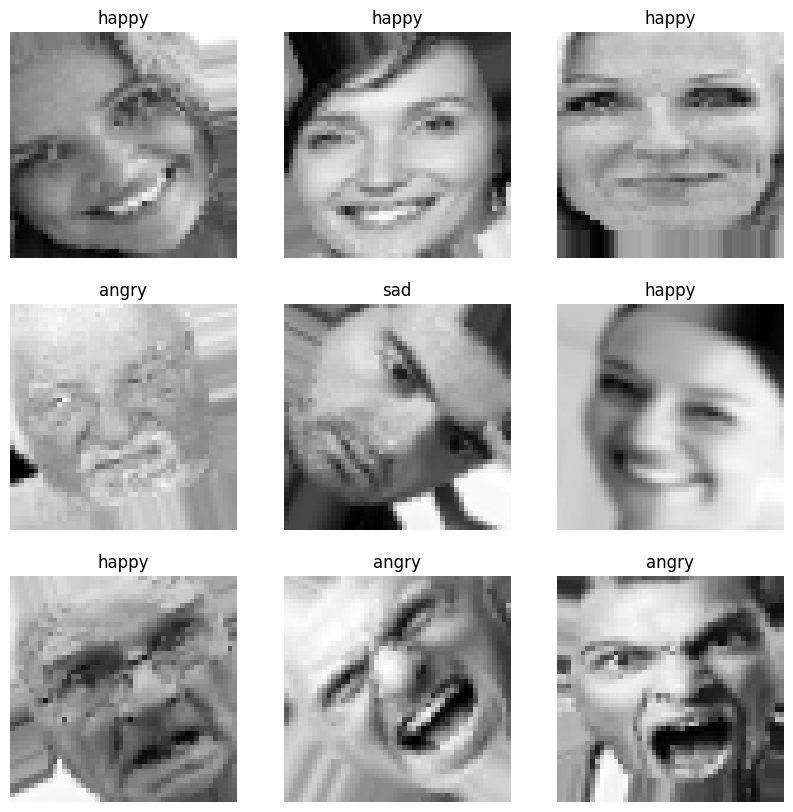

In [3]:
# --- Visualizar algunas imágenes de entrenamiento ---
plt.figure(figsize=(10, 10))
# Tomamos un lote de imágenes del generador
images, labels = next(train_generator)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # ImageDataGenerator devuelve lotes, por lo que usamos images[i]
    plt.imshow(images[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    plt.title(class_names[int(labels[i])])
    plt.axis("off")
plt.show()

## 4. Construcción de los Modelos de CNN

In [4]:
# --- Modelo 1: CNN Básica ---
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
], name="CNN_Basica")

# --- Modelo 2: CNN con Dropout ---
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
], name="CNN_Con_Dropout")

# --- Modelo 3: CNN Profunda con Batch Normalization y Dropout ---
model_3 = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=IMAGE_SHAPE),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
], name="CNN_Profunda_Normalizada")

# Lista de modelos para iterar
models = [model_1, model_2, model_3]

# Imprimir el resumen del modelo más complejo
print("--- Arquitectura del Modelo 3 ---")
model_3.summary()

--- Arquitectura del Modelo 3 ---


c:\Users\nefth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_Profunda_Normalizada"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,419 (2.61 MB)

 Trainable params: 683,715 (2.61 MB)

 Non-trainable params: 704 (2.75 KB)

## 5. Entrenamiento y Evaluación de los Modelos

c:\Users\nefth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


\n--- Entrenando CNN_Basica ---
Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.4825 - loss: 1.0332 - val_accuracy: 0.5518 - val_loss: 0.9307
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5520 - loss: 0.9421 - val_accuracy: 0.5896 - val_loss: 0.9082
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5816 - loss: 0.9094 - val_accuracy: 0.6295 - val_loss: 0.8365
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5897 - loss: 0.8812 - val_accuracy: 0.6067 - val_loss: 0.8463
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.6135 - loss: 0.8544 - val_accuracy: 0.6545 - val_loss: 0.7794
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.6329 - loss: 0.8208 - val_accuracy: 0.6708 - val_loss: 0.7561
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6346 - loss: 0.8010 - val_accuracy: 0.6716 - val_loss: 0.7452
Epoch 8/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 

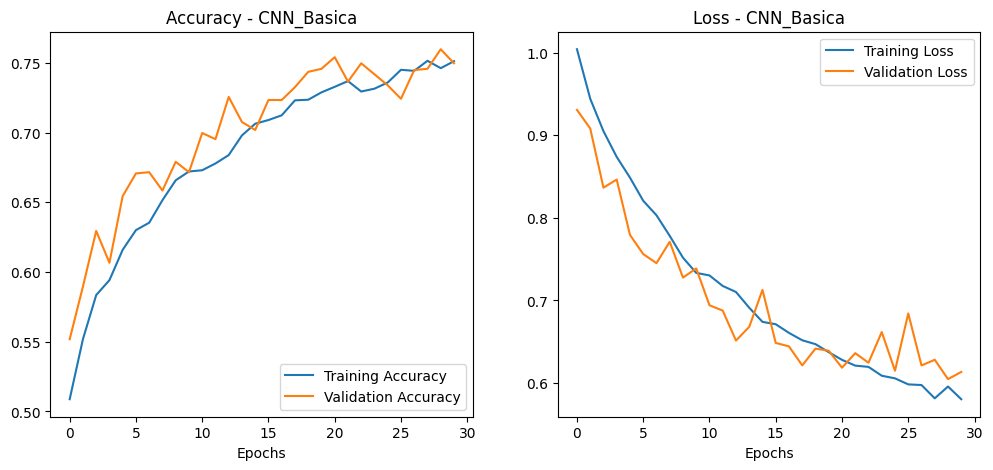

\n--- Entrenando CNN_Con_Dropout ---
Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.4574 - loss: 1.0615 - val_accuracy: 0.4952 - val_loss: 1.0127
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5097 - loss: 1.0078 - val_accuracy: 0.5338 - val_loss: 0.9577
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5259 - loss: 0.9841 - val_accuracy: 0.5347 - val_loss: 0.9664
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5382 - loss: 0.9654 - val_accuracy: 0.5417 - val_loss: 0.9771
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5549 - loss: 0.9503 - val_accuracy: 0.5729 - val_loss: 0.9063
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5547 - loss: 0.9397 - val_accuracy: 0.5843 - val_loss: 0.9043
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5689 - loss: 0.9182 - val_accuracy: 0.5817 - val_loss: 0.9107
Epoch 8/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accur

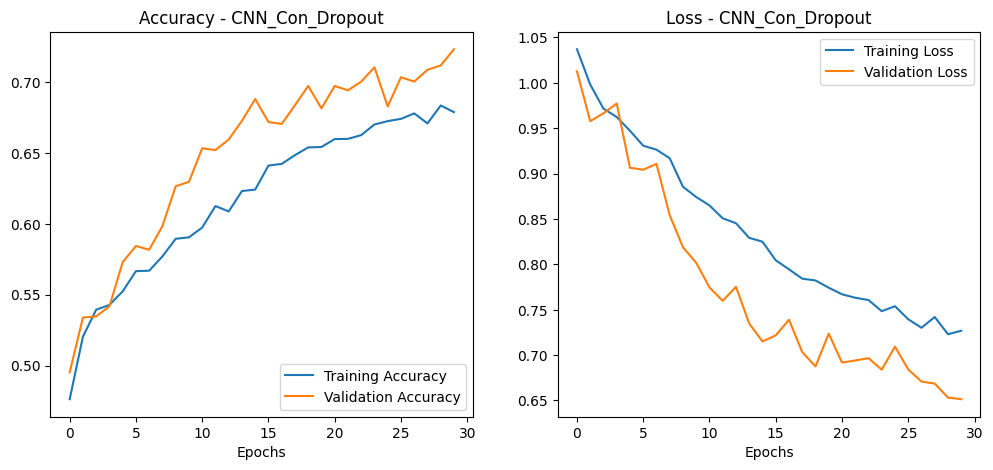

\n--- Entrenando CNN_Profunda_Normalizada ---
Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4094 - loss: 1.5123 - val_accuracy: 0.2265 - val_loss: 1.5370
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.4945 - loss: 1.1241 - val_accuracy: 0.4447 - val_loss: 1.3126
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.5323 - loss: 1.0111 - val_accuracy: 0.5399 - val_loss: 0.9383
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.5596 - loss: 0.9519 - val_accuracy: 0.5654 - val_loss: 0.9645
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.5718 - loss: 0.9183 - val_accuracy: 0.5395 - val_loss: 0.9454
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.5806 - loss: 0.8852 - val_accuracy: 0.6264 - val_loss: 0.8178
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5990 - loss: 0.8658 - val_accuracy: 0.6264 - val_loss: 0.8329
Epoch 8/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/st

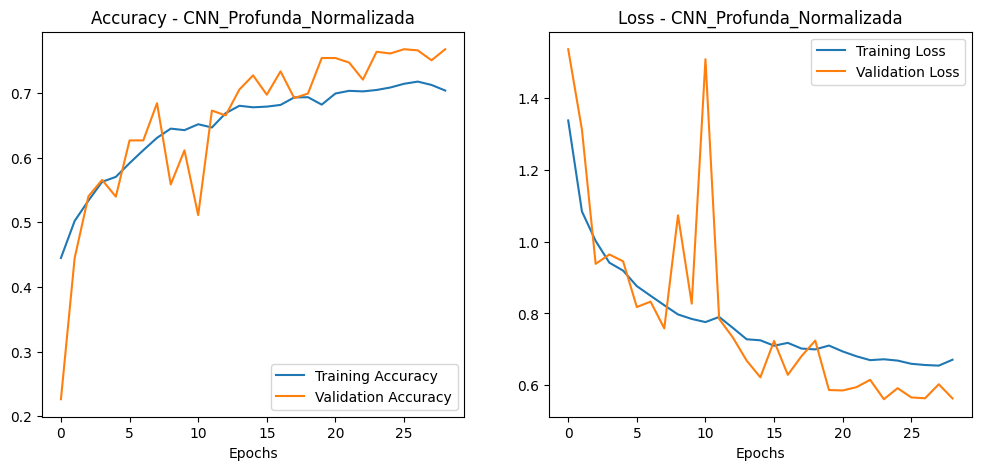

In [5]:
# --- Función para entrenar y graficar ---
def train_and_plot(model, train_data, test_data):
    """Compila, entrena y grafica el historial de un modelo de Keras."""
    
    # Compilación
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Parada temprana
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Entrenamiento
    print(f"\\n--- Entrenando {model.name} ---")
    history = model.fit(
        train_data,
        epochs=30, # Un número alto, EarlyStopping decidirá
        validation_data=test_data,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Graficar resultados
    metrics = pd.DataFrame(history.history)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics.index, metrics['accuracy'], label='Training Accuracy')
    plt.plot(metrics.index, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - {model.name}')
    plt.xlabel('Epochs')
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics.index, metrics['loss'], label='Training Loss')
    plt.plot(metrics.index, metrics['val_loss'], label='Validation Loss')
    plt.title(f'Loss - {model.name}')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    
    plt.show()
    
    return history

# --- Entrenar todos los modelos ---
histories = []
for model in models:
    history = train_and_plot(model, train_generator, test_generator)
    histories.append(history)

## 6. Evaluación Final y Selección del Mejor Modelo


In [6]:
# --- Evaluar todos los modelos en el conjunto de prueba ---
print("\\n--- Evaluación Final en el Conjunto de Prueba ---")
scores = []
for i, model in enumerate(models):
    score = model.evaluate(test_generator, verbose=0)
    print(f"Modelo {i+1} ({model.name}) - Pérdida: {score[0]:.4f}, Precisión: {score[1]:.4f}")
    scores.append(score[1])

# --- Seleccionar y guardar el mejor modelo ---
best_model_index = np.argmax(scores)
best_model = models[best_model_index]
best_model_name = best_model.name

print(f"\\nEl mejor modelo es: {best_model_name} con una precisión de {scores[best_model_index]:.4f}")

# Guardar el modelo completo
best_model.save("mejor_modelo_emociones.keras")
print("Mejor modelo guardado como 'mejor_modelo_emociones.keras'")

# Guardar los índices de las clases para su uso posterior
class_indices = train_generator.class_indices
joblib.dump(class_indices, "class_indices.pkl")
print("Índices de clases guardados como 'class_indices.pkl'")

\n--- Evaluación Final en el Conjunto de Prueba ---
Modelo 1 (CNN_Basica) - Pérdida: 0.6048, Precisión: 0.7599
Modelo 2 (CNN_Con_Dropout) - Pérdida: 0.6513, Precisión: 0.7230
Modelo 3 (CNN_Profunda_Normalizada) - Pérdida: 0.5607, Precisión: 0.7634
\nEl mejor modelo es: CNN_Profunda_Normalizada con una precisión de 0.7634
Mejor modelo guardado como 'mejor_modelo_emociones.keras'
Índices de clases guardados como 'class_indices.pkl'


## 7. Despliegue: Realizar una Predicción con el Modelo Guardado

Modelo y clases cargados exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


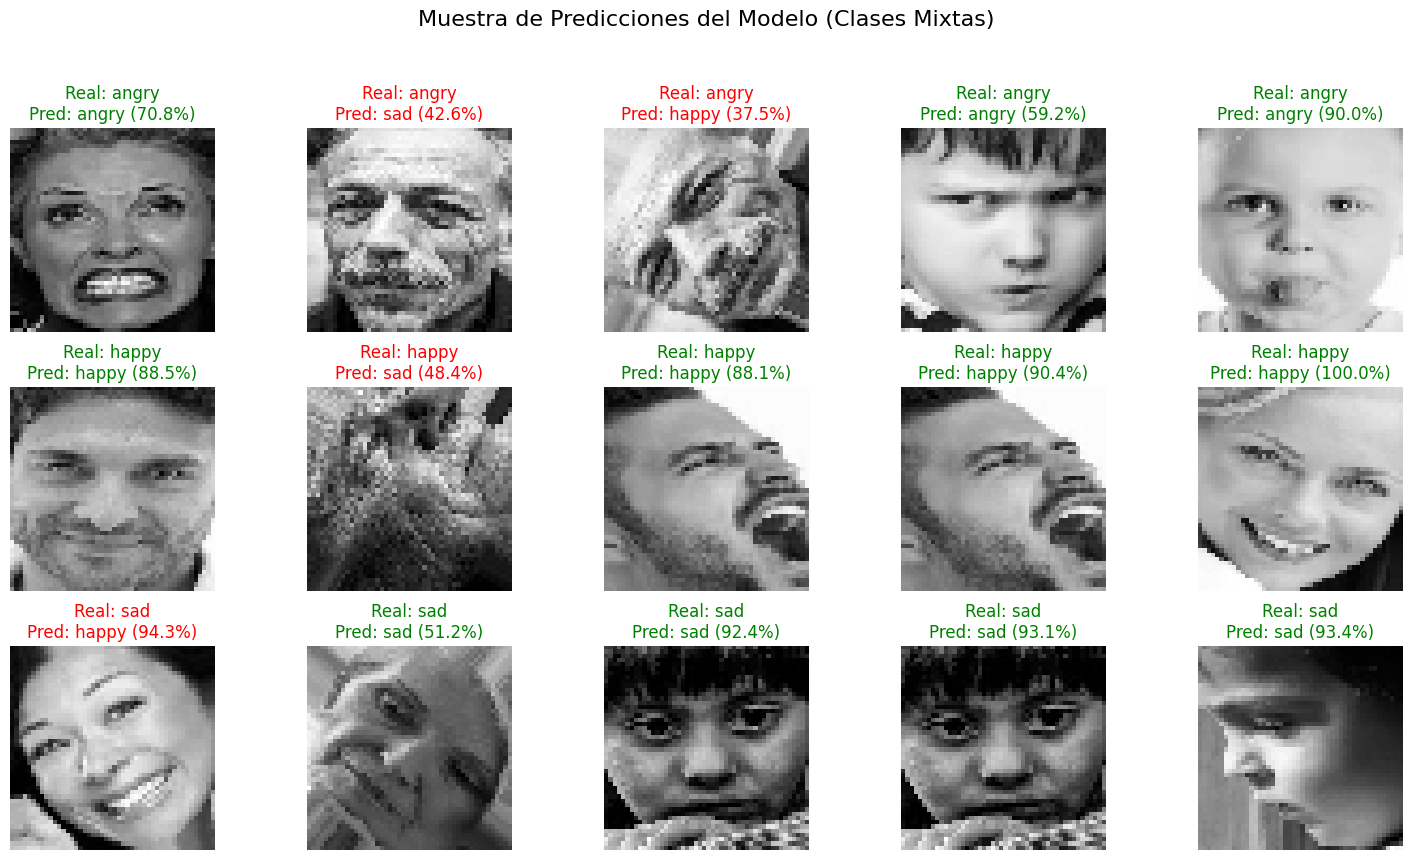

In [17]:
# --- Cargar el modelo y los índices de clases ---
loaded_model = load_model("mejor_modelo_emociones.keras")
loaded_class_indices = joblib.load("class_indices.pkl")
inv_class_indices = {v: k for k, v in loaded_class_indices.items()}
class_names = list(loaded_class_indices.keys())

print("Modelo y clases cargados exitosamente.")

# --- Seleccionar un número de imágenes de CADA categoría de prueba ---
images_to_predict = []
true_labels = []
num_samples_per_class = 5 # Puedes cambiar este número

for emotion in class_names:
    emotion_folder = os.path.join(test_dir, emotion)
    sample_images = os.listdir(emotion_folder)[:num_samples_per_class]
    
    for img_name in sample_images:
        img_path = os.path.join(emotion_folder, img_name)
        
        # Cargar y preprocesar la imagen
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
        img_array = image.img_to_array(img)
        img_array /= 255.0 # Normalizar
        
        images_to_predict.append(img_array)
        true_labels.append(emotion)

# Convertir la lista de imágenes a un lote (numpy array)
image_batch = np.array(images_to_predict)

# --- Realizar predicciones en todo el lote ---
prediction_probabilities = loaded_model.predict(image_batch)
predicted_indices = np.argmax(prediction_probabilities, axis=1)

# --- Visualizar las predicciones ---
plt.figure(figsize=(15, 9))
plt.suptitle("Muestra de Predicciones del Modelo (Clases Mixtas)", fontsize=16)

for i in range(len(image_batch)):
    ax = plt.subplot(3, 5, i + 1)
    
    # Mostrar la imagen
    plt.imshow(image_batch[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    
    # Obtener etiquetas
    true_emotion = true_labels[i]
    predicted_emotion = inv_class_indices[predicted_indices[i]]
    confidence = np.max(prediction_probabilities[i]) * 100
    
    # Determinar el color del título
    title_color = 'green' if true_emotion == predicted_emotion else 'red'
    
    # Establecer el título
    plt.title(
        f"Real: {true_emotion}\nPred: {predicted_emotion} ({confidence:.1f}%)",
        color=title_color
    )
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()